# Part 1- Exploratory Data Analysis

## Import Packages

In [1]:
import pandas as pd
import numpy as np
from sklearn import tree, metrics
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus

/Users/suhas/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [2]:
import json

## Load logins data

In [3]:
df = pd.read_json ('logins.json')

In [4]:
df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [5]:
with open('logins.json') as file:
    login_time_data = json.load(file)

In [6]:
type(login_time_data)

dict

In [7]:
login_time_data.keys()

dict_keys(['login_time'])

In [8]:
df.dtypes

login_time    datetime64[ns]
dtype: object

### Resampling data and counting no. of occurrences per 15-min. time period

In [9]:
df_15min=df.resample('15T', on='login_time').count()

In [10]:
df_15min.head()

,login_time
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


In [11]:
df_15min.index

DatetimeIndex(['1970-01-01 20:00:00', '1970-01-01 20:15:00',
               '1970-01-01 20:30:00', '1970-01-01 20:45:00',
               '1970-01-01 21:00:00', '1970-01-01 21:15:00',
               '1970-01-01 21:30:00', '1970-01-01 21:45:00',
               '1970-01-01 22:00:00', '1970-01-01 22:15:00',
               ...
               '1970-04-13 16:30:00', '1970-04-13 16:45:00',
               '1970-04-13 17:00:00', '1970-04-13 17:15:00',
               '1970-04-13 17:30:00', '1970-04-13 17:45:00',
               '1970-04-13 18:00:00', '1970-04-13 18:15:00',
               '1970-04-13 18:30:00', '1970-04-13 18:45:00'],
              dtype='datetime64[ns]', name='login_time', length=9788, freq='15T')

In [12]:
df_15min.columns.tolist()

['login_time']

In [13]:
df_15min.rename(columns={'login_time':'frequency'}, inplace=True)

In [14]:
df_15min.head()

,frequency
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


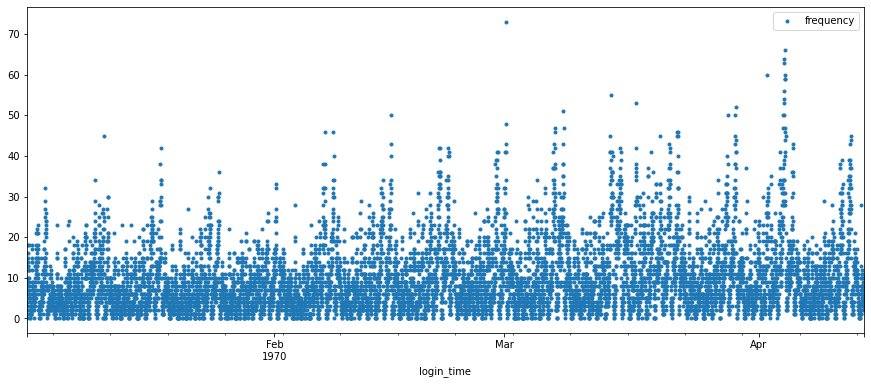

In [15]:
df_15min.plot(figsize=(15,6),style='.')

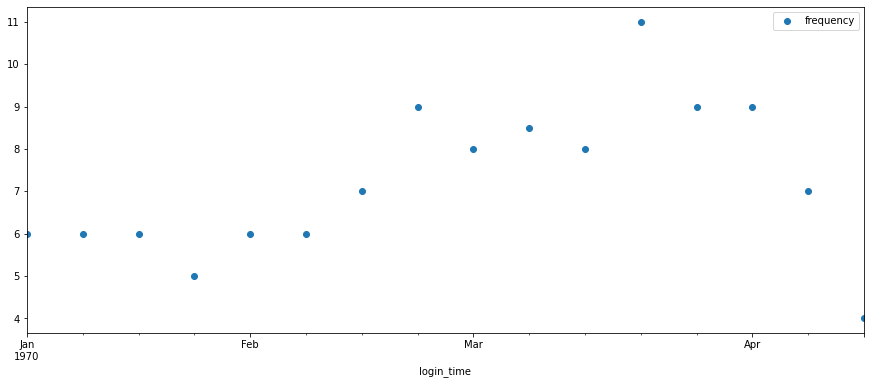

In [16]:
df_15min.resample("1w").median().plot(figsize=(15,6),style='o')

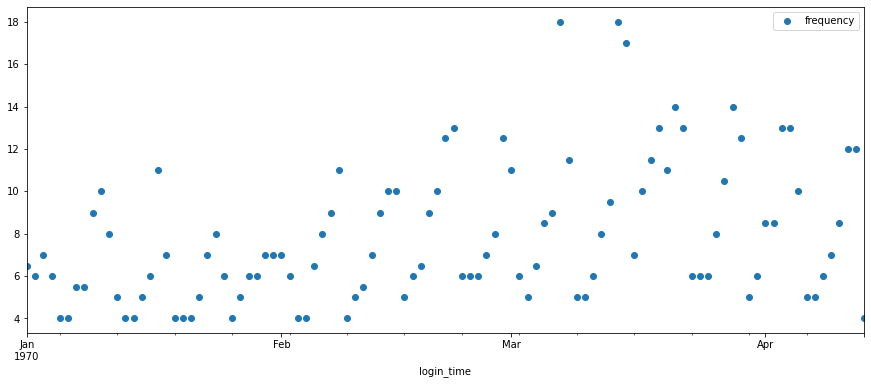

In [17]:
df_15min.resample("1D").median().plot(figsize=(15,6),style='o')

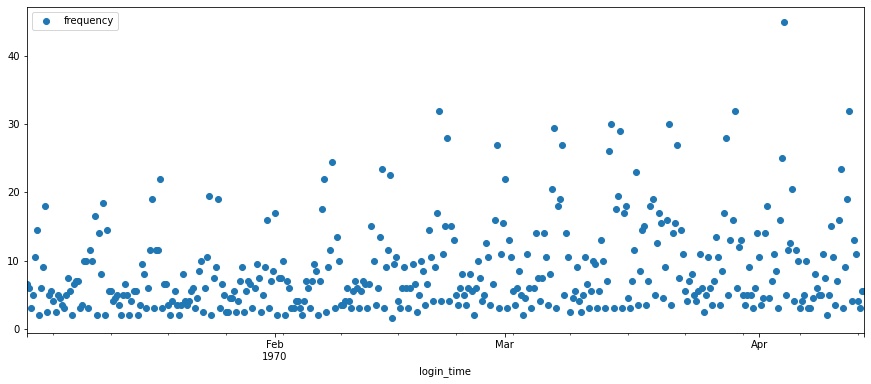

In [18]:
df_15min.resample("6H").median().plot(figsize=(15,6),style='o')

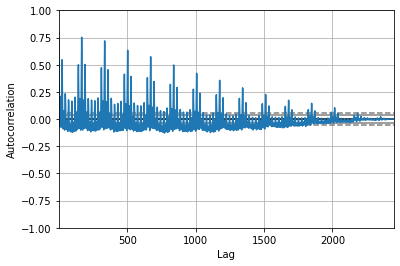

In [19]:
pd.plotting.autocorrelation_plot(df_15min.resample("1H").median())

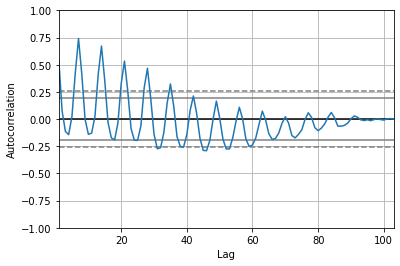

In [20]:
pd.plotting.autocorrelation_plot(df_15min.resample("1D").median())

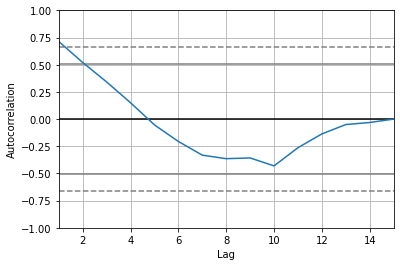

In [21]:
pd.plotting.autocorrelation_plot(df_15min.resample("7D").median())

#### The 15 minute aggregated data scatter plot clearly shows a cyclic login pattern. Plotting the autocorrelation shows a cyclic pattern that repeats every 7 days (1 week).

# Part 2 ‐ Experiment and metrics design

1. The ultimate managers would like the driver partners to be available in both cities. They are assuming that the 2-way toll is discouraging the drivers serving both cities. By reimbursing the toll, the managers hope that drivers will not worry about paying toll, leading to drivers being available to serve both cities.
The average number of cities served by drivers metric is the key measure of success of this experiment to encourage drivers to serve both cities. If the drivers of the cities are confining themselves to one city, the average number of cities served by drivers will be close to 1. However, for some reason, such as no toll payment, if the drivers decide to serve both cities the average will be close to 2. 

2. 

    * a. The managers can enroll 100 or so drivers from both cities for a study, and randomly select about 50% of drivers from both cities and provide them a no-toll tag. The average number of cities served by drivers data then can be compared between the 2, toll and no-toll, groups.

    * b. Assuming normal data distribution a t-test can be conducted to compare the means (avg. cities served) for the 2 groups (toll and no-toll). (For a large sample z-test can be used).

    * c. The p-value will be obtained for the test. A large p-value will indicate that the null hypothesis, the toll has no effect on number of cities served by the driver, is true. A small p-value  will imply that removing of toll had a desirable effect. The p-value threshold of, e.g. 0.05 or 0.01, will have to be decided by the managers to balance the possibility of type-1 error. 
Additionally, the averaging time period should be given consideration. Since, both cities are active on different time-of-day, averaging over a duration less than 12 hours should also be considered. 


# Part 3 ‐ Predictive modeling

## 1. Data wrangling and EDA
### Load data

In [22]:
df_rider = pd.read_json ('ultimate_data_challenge.json')

In [23]:
df_rider.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [24]:
df_rider.columns

Index(['city', 'trips_in_first_30_days', 'signup_date', 'avg_rating_of_driver',
       'avg_surge', 'last_trip_date', 'phone', 'surge_pct',
       'ultimate_black_user', 'weekday_pct', 'avg_dist',
       'avg_rating_by_driver'],
      dtype='object')

In [25]:
df_rider.dtypes

city                       object
trips_in_first_30_days      int64
signup_date                object
avg_rating_of_driver      float64
avg_surge                 float64
last_trip_date             object
phone                      object
surge_pct                 float64
ultimate_black_user          bool
weekday_pct               float64
avg_dist                  float64
avg_rating_by_driver      float64
dtype: object

In [26]:
df_rider.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


#### Note a few null entries exist in both ratings and phone columns.

### Data Wrangling

In [27]:
# number of unique values per column
(df_rider.nunique()/df_rider.shape[0])*100



city                      0.006
trips_in_first_30_days    0.118
signup_date               0.062
avg_rating_of_driver      0.074
avg_surge                 0.230
last_trip_date            0.364
phone                     0.004
surge_pct                 0.734
ultimate_black_user       0.004
weekday_pct               1.332
avg_dist                  5.816
avg_rating_by_driver      0.054
dtype: float64

In [28]:
#number of unique cities
df_rider['city'].unique()

array(["King's Landing", 'Astapor', 'Winterfell'], dtype=object)

In [29]:
#number of unique phones
df_rider['phone'].unique()

array(['iPhone', 'Android', None], dtype=object)

In [30]:
#number of ultimate_black_user tags (expecting either true or flase)
df_rider['ultimate_black_user'].unique()

array([ True, False])

#### Data cleaning

In [33]:
#Look for duplicate rows
duplicateRowsDF = df_rider[df_rider.duplicated()]
duplicateRowsDF

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
2608,Astapor,1,2014-01-18,5.0,1.0,2014-01-19,iPhone,0.0,True,0.0,6.25,5.0
18057,Astapor,1,2014-01-11,5.0,1.0,2014-01-11,iPhone,0.0,True,0.0,2.33,5.0
29601,Winterfell,1,2014-01-01,NaN,1.0,2014-01-02,Android,0.0,False,100.0,8.08,5.0
34641,Winterfell,1,2014-01-18,NaN,1.0,2014-01-19,iPhone,0.0,True,0.0,1.44,5.0
36627,Winterfell,1,2014-01-18,5.0,1.0,2014-01-19,Android,0.0,False,0.0,3.54,5.0
39601,Winterfell,1,2014-01-10,5.0,1.0,2014-01-11,Android,0.0,False,100.0,0.00,5.0
42025,Winterfell,1,2014-01-18,NaN,1.0,2014-01-19,Android,0.0,False,0.0,0.01,5.0
45416,Astapor,1,2014-01-20,5.0,1.0,2014-01-20,iPhone,0.0,False,100.0,3.06,5.0


In [36]:
# Dropping duplicates
df_rider.drop_duplicates(inplace=True)

In [37]:
#Look for duplicate rows
duplicateRowsDF = df_rider[df_rider.duplicated()]
duplicateRowsDF

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver


In [38]:
# Dropping rows with Nan values
df_rider.dropna(inplace=True)

In [40]:
df_rider.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41440 entries, 0 to 49998
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    41440 non-null  object 
 1   trips_in_first_30_days  41440 non-null  int64  
 2   signup_date             41440 non-null  object 
 3   avg_rating_of_driver    41440 non-null  float64
 4   avg_surge               41440 non-null  float64
 5   last_trip_date          41440 non-null  object 
 6   phone                   41440 non-null  object 
 7   surge_pct               41440 non-null  float64
 8   ultimate_black_user     41440 non-null  bool   
 9   weekday_pct             41440 non-null  float64
 10  avg_dist                41440 non-null  float64
 11  avg_rating_by_driver    41440 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 3.8+ MB


In [41]:
#number of unique phones
df_rider['phone'].unique()

array(['iPhone', 'Android'], dtype=object)

### EDA

#### First a column of retained drivers is created

In [43]:
# converting to timestamp dtype
df_rider['signup_date'] = pd.to_datetime(df_rider['signup_date'])

In [44]:
# converting to timestamp dtype
df_rider['last_trip_date'] = pd.to_datetime(df_rider['last_trip_date'])

In [45]:
#calculating difference
df_rider['timediff']=df_rider['last_trip_date']-df_rider['signup_date']

In [46]:
df_rider['retained_user']=0

In [48]:
#defining retained user the one that is available 5 months later
df_rider['retained_user'].loc[df_rider['timediff']>'5M']=1

/Users/suhas/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [55]:
df_rider['timediff'].head()

0   143 days
1    96 days
2     1 days
3   170 days
4    47 days
Name: timediff, dtype: timedelta64[ns]

In [58]:
df_rider['nb_months'] = ((df_rider['timediff'])/np.timedelta64(1, 'M'))

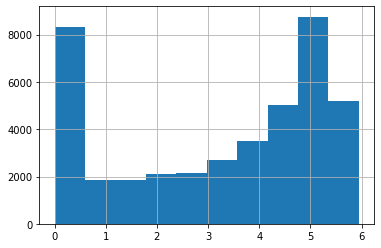

In [59]:
df_rider['nb_months'].hist()

In [62]:
# retained user are the ones comming back after 5 months
df_rider['retained_user']=0
df_rider['retained_user'].loc[df_rider['nb_months']>5]=1

/Users/suhas/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [63]:
#number of unique retained users
df_rider['retained_user'].unique()

array([0, 1])

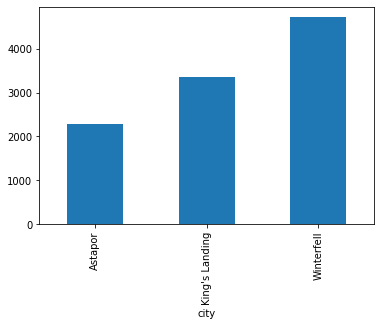

In [64]:
# number of retained users grouped by city
df_rider.groupby(['city'])['retained_user'].sum().plot.bar()

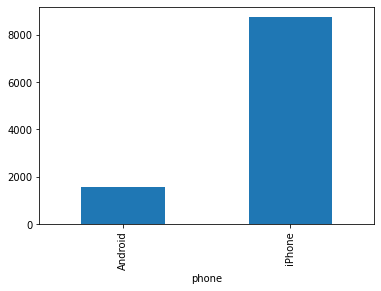

In [65]:
# number of retained users grouped by phone
df_rider.groupby(['phone'])['retained_user'].sum().plot.bar()

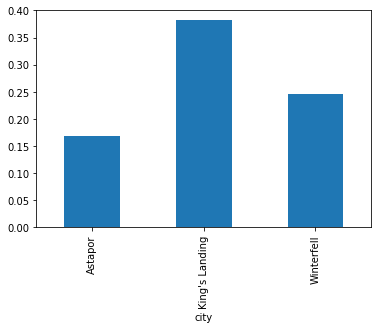

In [66]:
# number of retained users grouped by city
df_rider.groupby(['city'])['retained_user'].mean().plot.bar()

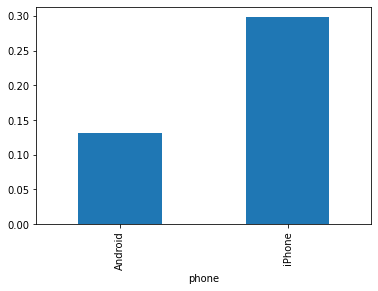

In [67]:
# number of retained users grouped by phone
df_rider.groupby(['phone'])['retained_user'].mean().plot.bar()

#### Proportion of retained users is higher for King's landing and iphone users

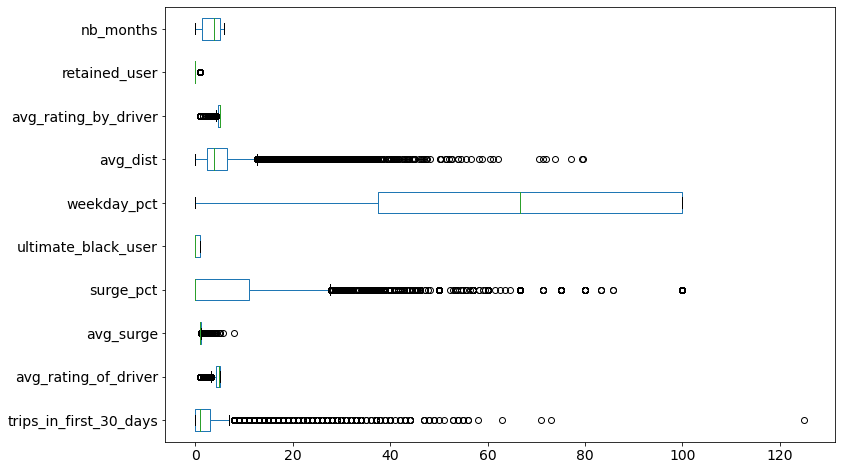

In [68]:
#Anomalies and extreme value review
boxplot = df_rider.boxplot(grid=False, vert=False,figsize=[12,8],fontsize=14)



The two avg_rating columns, avg distance, trips in first 30 days and surge_pct seem to have most extreme values, however, those seem to be in range.

#### Exploring data relationships below

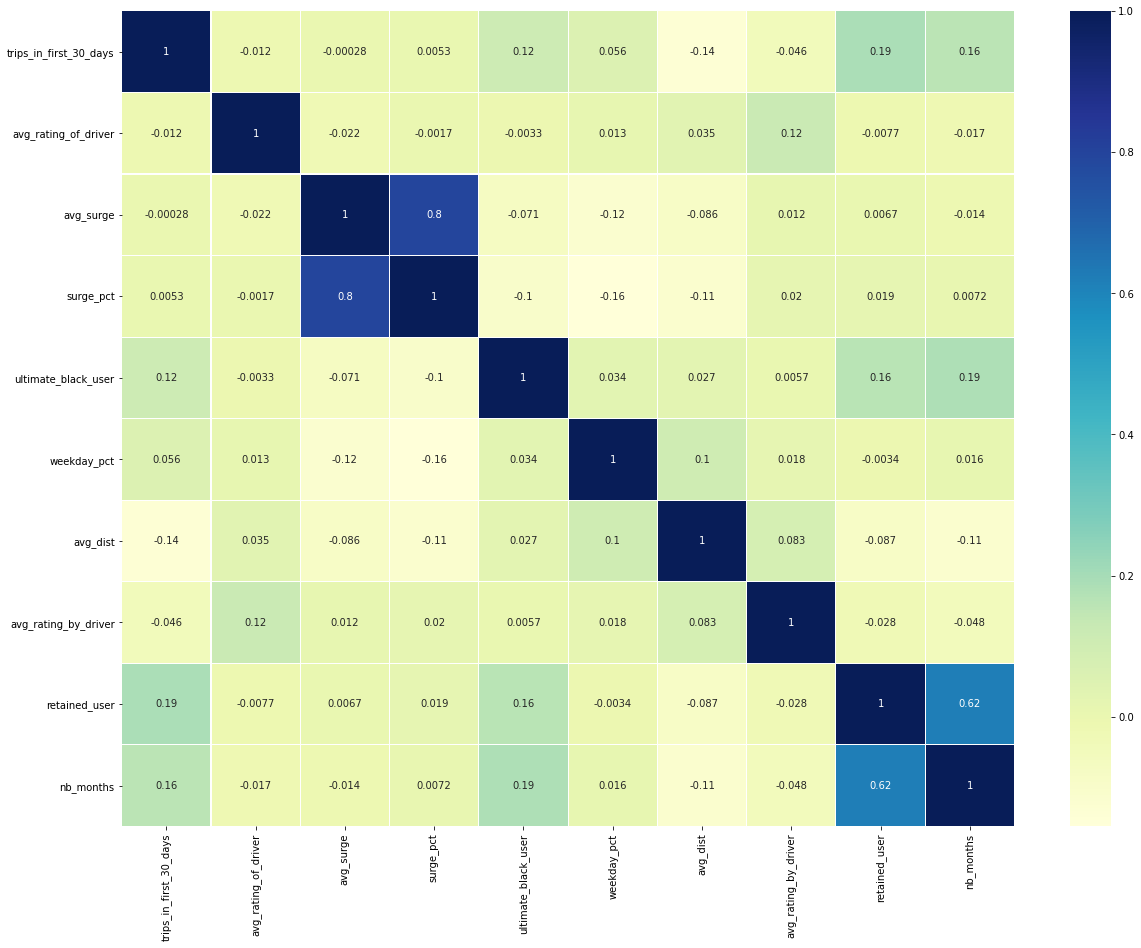

In [70]:
plt.figure(figsize=(20,15))
sns.heatmap(df_rider.corr(),linewidths=.1,cmap="YlGnBu", annot=True)

#### Avg_surge and surge_pct columns seem to be correlated to each other, however correlation being below 0.95, both columns will be used. Further, the nb_months column will not be used since it was used to obtain the retained user column.

## 2. Data preparation and modeling

### Create dummy features for categorical variables

In [73]:
df_rider.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41440 entries, 0 to 49998
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype          
---  ------                  --------------  -----          
 0   city                    41440 non-null  object         
 1   trips_in_first_30_days  41440 non-null  int64          
 2   signup_date             41440 non-null  datetime64[ns] 
 3   avg_rating_of_driver    41440 non-null  float64        
 4   avg_surge               41440 non-null  float64        
 5   last_trip_date          41440 non-null  datetime64[ns] 
 6   phone                   41440 non-null  object         
 7   surge_pct               41440 non-null  float64        
 8   ultimate_black_user     41440 non-null  bool           
 9   weekday_pct             41440 non-null  float64        
 10  avg_dist                41440 non-null  float64        
 11  avg_rating_by_driver    41440 non-null  float64        
 12  timediff                41440 no

In [74]:
df_rider = pd.concat([df_rider.drop('city', axis=1), pd.get_dummies(df_rider.city)], axis=1)

In [75]:
df_rider = pd.concat([df_rider.drop('phone', axis=1), pd.get_dummies(df_rider.phone)], axis=1)

In [76]:
df_rider.head().T

,0,1,2,3,4
trips_in_first_30_days,4,0,3,9,14
signup_date,2014-01-25 00:00:00,2014-01-29 00:00:00,2014-01-06 00:00:00,2014-01-10 00:00:00,2014-01-27 00:00:00
avg_rating_of_driver,4.7,5,4.3,4.6,4.4
avg_surge,1.1,1,1,1.14,1.19
last_trip_date,2014-06-17 00:00:00,2014-05-05 00:00:00,2014-01-07 00:00:00,2014-06-29 00:00:00,2014-03-15 00:00:00
surge_pct,15.4,0,0,20,11.8
ultimate_black_user,True,False,False,True,False
weekday_pct,46.2,50,100,80,82.4
avg_dist,3.67,8.26,0.77,2.36,3.13
avg_rating_by_driver,5,5,5,4.9,4.9


In [81]:
df_rider.columns

Index(['trips_in_first_30_days', 'signup_date', 'avg_rating_of_driver',
       'avg_surge', 'last_trip_date', 'surge_pct', 'ultimate_black_user',
       'weekday_pct', 'avg_dist', 'avg_rating_by_driver', 'timediff',
       'retained_user', 'nb_months', 'Astapor', 'King's Landing', 'Winterfell',
       'Android', 'iPhone'],
      dtype='object')

In [83]:
features = ['trips_in_first_30_days', 'avg_rating_of_driver',
       'avg_surge',  'surge_pct', 'ultimate_black_user',
       'weekday_pct', 'avg_dist', 'avg_rating_by_driver',
        'Astapor', "King's Landing", 'Winterfell',
       'Android', 'iPhone' ]

In [84]:
X = df_rider[features]
y = df_rider['retained_user']

In [99]:
#Split the data into test and train subsamples

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=1)

In [100]:
#scale data
from sklearn import preprocessing
import numpy as np
# build scaler based on training data and apply it to test data to then also scale the test data
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [101]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import accuracy_score,log_loss
from matplotlib import pyplot

### Fit Random Forest Classifier

In [102]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=5,n_estimators=300, random_state = 1,n_jobs=-1)
model_res = clf.fit(X_train_scaled, y_train)
y_pred = model_res.predict(X_test_scaled)
y_pred_prob = model_res.predict_proba(X_test_scaled)
lr_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

print('Random Forest: Accuracy=%.3f' % (ac))

print('Random Forest: f1-score=%.3f' % (f1))

Random Forest: Accuracy=0.775
Random Forest: f1-score=0.742


### Create Confusion Matrix Plots

In [103]:
class_names=['non-retained user','retained user'] # name  of classes

Confusion matrix, without normalization
[[7293  452]
 [1878  737]]
Normalized confusion matrix
[[0.94 0.06]
 [0.72 0.28]]


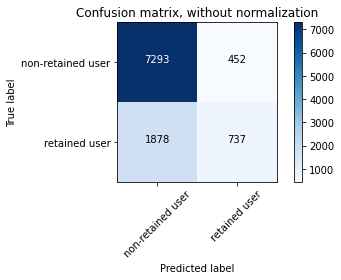

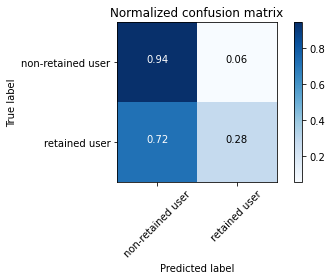

In [104]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
#plt.savefig('figures/RF_cm_multi_class.png')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
#plt.savefig('figures/RF_cm_proportion_multi_class.png', bbox_inches="tight")
plt.show()

### Plot feature importances

13


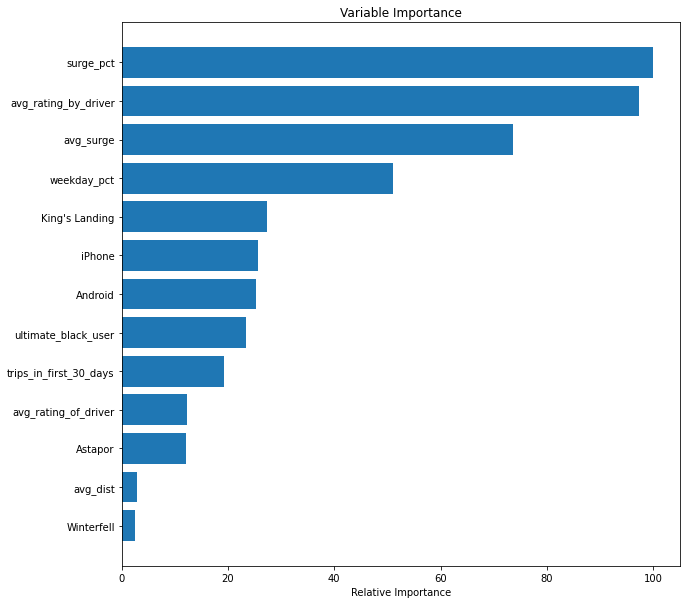

In [105]:
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

## 3. Ultimate Insights

Based on the above analysis, the top 3 variables in order of importance are: surge_pct, avg_rating_by_diver, and avg_surge. These variables should be measured accurately for future  retained customer prediction.
Further, the random forest classifying model used above seems to be better at predicting the non-retained user better. The following steps should be taken to improve model performance:
1. more data on retained customers
2. bootstrapping of retained customer data to reduce the class imbalance
3. better filter the data (for example extreme values were not treated in the above approach)
